In [46]:
%matplotlib inline
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
from skimage.measure import compare_ssim
import statistics

In [2]:
img_dir = "img1"
gt_path = "gt/gt.txt"

In [3]:
header_list = ['frame','trajectory','x','y','w','h','dco','class','visibility']
dtype = {
    'frame':int,
    'trajectory':int,
    'x':int,
    'y':int,
    'w':int,
    'h':int,
    'dco':int,
    'class':int,
    'visibility':float}

df = pd.read_csv(gt_path, names=header_list, dtype=dtype)

In [4]:
target_tracks = range(1,100,2)
patch_tracks = {}

for track_id in target_tracks:

    track_df = df[df['trajectory']==track_id]

    if len(track_df) < 150:
        continue    

    patches = []

    for row in track_df.itertuples(index=True, name='Pandas'):

        if row.dco == 0:
            continue

        img_path = os.path.join(img_dir, "%06d.jpg" % row.frame)

        color_img = cv2.imread(img_path)
        gray_img1 = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)

        start_x, start_y = int(round(row.x)), int(round(row.y))
        end_x, end_y = start_x + int(round(row.w)), start_y + int(round(row.h))

        crop = gray_img1[start_y:end_y, start_x:end_x]

        out_path = os.path.join("output/images","track_%s_frame_%s.jpeg" % (track_id,row.frame))
        cv2.imwrite(out_path, crop) 

        patch = {
            "track_id": track_id,
            "frame_id": row.frame,
            "image": crop,
            "path": img_path,
            "x": row.x,
            "y": row.y,
            "w": row.x,
            "h": row.h,
            "vis": row.visibility
        }

        patches.append(patch)
        if len(patches) >= 150:
            break

    if len(patches) == 150:
        print("track: %s, length: %s"%(track_id, len(patches)))
        patch_tracks[track_id] = patches

track: 1, length: 150
track: 3, length: 150
track: 5, length: 150
track: 63, length: 150
track: 65, length: 150
track: 67, length: 150
track: 69, length: 150
track: 71, length: 150
track: 75, length: 150
track: 83, length: 150
track: 85, length: 150
track: 87, length: 150
track: 89, length: 150
track: 91, length: 150
track: 93, length: 150
track: 95, length: 150
track: 97, length: 150
track: 99, length: 150


In [283]:
patch_tracks[95][40]['image']

array([[126, 167, 185, ..., 114, 113, 112],
       [124, 168, 189, ..., 105, 104, 103],
       [126, 159, 173, ...,  98,  97,  96],
       ...,
       [ 67,  65,  65, ...,  62,  63,  63],
       [ 67,  65,  64, ...,  63,  63,  63],
       [ 66,  64,  64, ...,  63,  64,  63]], dtype=uint8)

In [5]:
def sift(a,b):
    
    sift = cv2.xfeatures2d.SIFT_create()

    try:
        keypoints_1, descriptors_1 = sift.detectAndCompute(a,None)        
        keypoints_2, descriptors_2 = sift.detectAndCompute(b,None)
    except Exception as ex:
        print(str(ex), end=" ")
        return 0 
    
    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)
        
    try:
        matches = flann.knnMatch(descriptors_1,descriptors_2,k=2)
    except Exception as ex:
        print(str(ex), end=" ")
        return 0

    good_matches = []

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    epsilon = 1e-5

    try:
        return len(good_matches)/(len(matches)+epsilon)
    except Exception as ex:
        print(str(ex), end=" ")
        return 0

In [14]:
def akaze(a,b):
    akaze = cv2.AKAZE_create()

    try:
        kpts1, desc1 = akaze.detectAndCompute(a, None)
        kpts2, desc2 = akaze.detectAndCompute(b, None)
    except:
        return 0
    
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
    
    try:
        matches = matcher.knnMatch(desc1, desc2, 2)
    except:
        return 0
    
    good_matches = []
    
#     for m, n in matches:
#         if m.distance < 0.8 * n.distance:
#             good_matches.append(m)
    
    for i, m_n in enumerate(matches):
        if len(m_n) != 2:
            continue
        m,n = m_n
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    epsilon = 1e-5

    try:
        return len(good_matches)/(len(matches)+epsilon)
    except Exception as ex:
        # print(ex)
        return 0

In [15]:
MAX_FEATURES = 1000

def orb(a,b):
    #return 0 # just not working
    
    # Initiate STAR detector
    orb = cv2.ORB_create(nfeatures=100000, scoreType=cv2.ORB_FAST_SCORE)

    try:
        kp1, des1 = orb.detectAndCompute(a,None)
        kp2, des2 = orb.detectAndCompute(b,None)
    except Exception as ex:
        # print(ex)
        return 0

    # bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # matches = bf.match(des1,des2)
    # matches = sorted(matches, key = lambda x:x.distance)
    FLANN_INDEX_LSH = 6

    index_params= dict(algorithm = FLANN_INDEX_LSH,
                       table_number = 12, 
                       key_size = 20,     
                       multi_probe_level = 2)

    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    try:
        matches = flann.knnMatch(des1,des2,k=2)
    except Exception as ex:
        # print(ex)
        return 0
    
#     if len(matches)>0:
#         print("%d total matches found" % len(matches))
#     else:
#         print("No matches were found")
        
    
    good_matches = []

    for i, m_n in enumerate(matches):
        if len(m_n) != 2:
            continue
        m,n = m_n
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    epsilon = 1e-5

    try:
        return len(good_matches)/(len(matches)+epsilon)
    except Exception as ex:
        # print(ex)
        return 0

In [16]:
def ssim(a, b):
    (score, diff) = compare_ssim(a, b, full=True)
    diff = (diff * 255).astype("uint8")
    return score

In [58]:
def compare(a, b):
    img_a = a['image']
    img_b = b['image']
    
    try:
        eq1 = cv2.equalizeHist(img_a)
        eq2 = cv2.equalizeHist(img_b)
    except:
        return (0,0,0)
    
    dim = (66,180)
    try:
        eq_scaled_1 = cv2.resize(eq1, dim, interpolation=cv2.INTER_AREA)
        eq_scaled_2 = cv2.resize(eq2, dim, interpolation=cv2.INTER_AREA)
    except:
        return (0,0,0)
    
    akaze_score = akaze(eq_scaled_1,eq_scaled_2)
    sift_score = sift(eq_scaled_1,eq_scaled_2)
    # orb_score = orb(eq_scaled_1,eq_scaled_2)
    ssim_score = ssim(eq_scaled_1,eq_scaled_2)
    
    return (akaze_score, sift_score, ssim_score)

In [59]:
left_scores = []
right_scores = []
across = []

In [60]:
# track: 1, length: 150
# track: 3, length: 150
# track: 5, length: 150
# track: 63, length: 150
# track: 65, length: 150
# track: 67, length: 150
# track: 69, length: 150
# track: 71, length: 150
# track: 75, length: 150
# track: 83, length: 150
# track: 85, length: 150
# track: 87, length: 150
# track: 89, length: 150
# track: 91, length: 150
# track: 93, length: 150
# track: 95, length: 150
# track: 97, length: 150
# track: 99, length: 150

for _ in range(2,14):
    keys = list(patch_tracks.keys())
    
    left = patch_tracks[keys[_]]
    right = patch_tracks[keys[_+1]]

    for i in range(2,150):

        left_previous, left_current = left[i-1], left[i]
        right_previous, right_current = right[i-1], right[i]

        intra_left = compare(left_previous, left_current)
        intra_right = compare(right_previous, right_current)
        inter = compare(left_current, right_current)

        left_scores.append(intra_left)
        right_scores.append(intra_right)
        across.append(inter)

/home/bosworth/.envs/three/motaustin/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


In [61]:
# results = [(left_scores, right_scores, across)]
results.append((left_scores, right_scores, across))


sift
~~~~

left	right	across


1.00	1.00	0.54	max
0.00	0.00	0.00	min
0.47	0.48	0.03	mean
0.19	0.18	0.06	stdev

3552

ssim
~~~~

left	right	across


0.98	0.98	0.74	max
0.00	0.00	0.00	min
0.79	0.80	0.24	mean
0.18	0.17	0.16	stdev

3552

sift
~~~~

left	right	across


0.77	0.77	0.27	max
0.00	0.00	0.00	min
0.36	0.37	0.02	mean
0.16	0.15	0.04	stdev

1776

ssim
~~~~

left	right	across


0.95	0.95	0.34	max
0.00	0.00	0.00	min
0.70	0.72	0.11	mean
0.16	0.15	0.05	stdev

1776


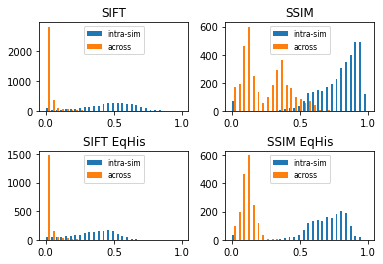

In [92]:
fig, axs = plt.subplots(2,2)
#axs[0,0].plot(x, y)
axs[0,0].set_title('SIFT')
#axs[0,1].plot(x, y)
axs[0,1].set_title('SSIM')
#axs[1,0].plot(x, y)
axs[1,0].set_title('SIFT EqHis')
#axs[1,1].plot(x, y)
axs[1,1].set_title('SSIM EqHis')
fig.subplots_adjust(hspace=0.45,wspace=0.25)
# fig.set_size_inches(5,4)

for t, (left_scores, right_scores, across) in enumerate(results):
    for i,name in [(1,"sift"),(2,"ssim")]: # [(0,"akaze"),(1,"sift"),(2,"ssim")]:

        print("\n%s\n%s\n\nleft\tright\tacross\n" % (name,'~'*len(name)))

        i_left = [x[i] for x in left_scores]
        i_right = [x[i] for x in right_scores]
        i_across = [x[i] for x in across]

        print("\n%.2f\t%.2f\t%.2f\tmax"%(max(i_left), max(i_right), max(i_across)))
        print("%.2f\t%.2f\t%.2f\tmin"%(min(i_left), min(i_right), min(i_across)))
        print("%.2f\t%.2f\t%.2f\tmean"%(statistics.mean(i_left), statistics.mean(i_right), statistics.mean(i_across)))
        print("%.2f\t%.2f\t%.2f\tstdev\n"%(statistics.stdev(i_left), statistics.stdev(i_right), statistics.stdev(i_across)))

        #_, bins, _ = plt.hist(i_left, bins=50, range=[-6, 6], normed=True)
        #_ = plt.hist(i_across, bins=bins, alpha=0.5, normed=True)

        bins = np.linspace(0, 1, 30)

        # plt.hist([i_left, i_across], bins, label=['intra-sim', 'across'])
        # plt.legend(loc='upper right')
        # plt.show()
        
        print(len(i_across))
        
        axs[t,i-1].hist([i_left, i_across], bins, label=['intra-sim', 'across'])
        axs[t,i-1].legend(loc='upper center',prop={'size':7.5})

fig.savefig('/home/bosworth/Downloads/sift_ssid.png')
        
# for i in range(150):
#    print("%.2f\t%.2f\t%.2f" % (sift_left[i], sift_right[i], sift_across[i]))

In [35]:
# equalizing histogram
# positive matches reduced for sift and ssid
# but false positives reduced much more than true positives using ssim
# akaze true positive rate doubled

# akaze
# ~~~~~

# left	right	across


# 1.00	1.00	1.00	max
# 0.00	0.00	0.00	min
# 0.56	0.56	0.06	mean
# 0.39	0.39	0.19	stdev

# 1776

# sift
# ~~~~

# left	right	across


# 0.77	0.77	0.27	max
# 0.00	0.00	0.00	min
# 0.36	0.37	0.02	mean
# 0.16	0.15	0.04	stdev

# 1776

# ssim
# ~~~~

# left	right	across


# 0.95	0.95	0.34	max
# 0.00	0.00	0.00	min
# 0.70	0.72	0.11	mean
# 0.16	0.15	0.05	stdev

# 1776

In [22]:
# no histogram equalization

# akaze
# ~~~~~

# left	right	across


# 1.00	1.00	1.00	max
# 0.00	0.00	0.00	min
# 0.23	0.23	0.01	mean
# 0.39	0.39	0.08	stdev

# 1776

# sift
# ~~~~

# left	right	across


# 1.00	1.00	0.54	max
# 0.00	0.00	0.00	min
# 0.59	0.58	0.04	mean
# 0.15	0.14	0.08	stdev

# 1776

# ssim
# ~~~~

# left	right	across


# 0.98	0.98	0.74	max
# 0.00	0.00	0.00	min
# 0.87	0.87	0.37	mean
# 0.15	0.15	0.12	stdev

# 1776
# scaling all images to (66,180)

In [464]:
# sift (goodness threshold = 0.6)

# left	right	across


# 1.00	1.00	0.62	max
# 0.00	0.00	0.00	min
# 0.54	0.53	0.02	mean

# 1628


In [ ]:
# sift (0.65 goodness threshold)

# left	right	across


# 1.00	1.00	0.62	max
# 0.00	0.17	0.00	min
# 0.55	0.56	0.03	mean

# 1776

In [ ]:
# sift (0.75 goodness score)

# left	right	across


# 1.00	1.00	0.64	max
# 0.00	0.00	0.00	min
# 0.59	0.58	0.06	mean

# 1776

In [ ]:
# sift (0.8 goodness threshold)

# left	right	across


# 1.00	1.00	0.78	max
# 0.00	0.00	0.00	min
# 0.62	0.61	0.10	mean

# 1776


akaze
~~~~~

left	right	across


1.00	1.00	1.00	max
0.00	0.00	0.00	min
0.56	0.56	0.06	mean
0.39	0.39	0.19	stdev



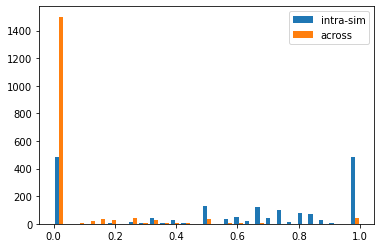

1776

sift
~~~~

left	right	across


0.77	0.77	0.27	max
0.00	0.00	0.00	min
0.36	0.37	0.02	mean
0.16	0.15	0.04	stdev



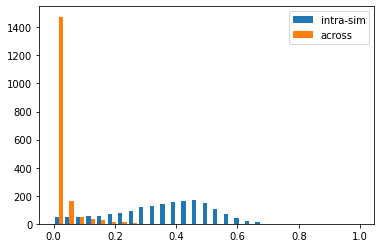

1776

ssim
~~~~

left	right	across


0.95	0.95	0.34	max
0.00	0.00	0.00	min
0.70	0.72	0.11	mean
0.16	0.15	0.05	stdev



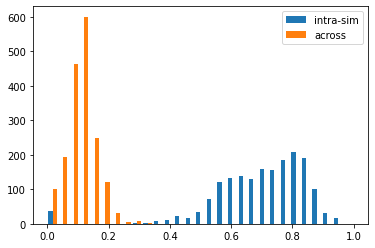

1776


In [51]:
for i,name in [(0,"akaze"),(1,"sift"),(2,"ssim")]:
    
    print("\n%s\n%s\n\nleft\tright\tacross\n" % (name,'~'*len(name)))

    i_left = [x[i] for x in left_scores]
    i_right = [x[i] for x in right_scores]
    i_across = [x[i] for x in across]

    print("\n%.2f\t%.2f\t%.2f\tmax"%(max(i_left), max(i_right), max(i_across)))
    print("%.2f\t%.2f\t%.2f\tmin"%(min(i_left), min(i_right), min(i_across)))
    print("%.2f\t%.2f\t%.2f\tmean"%(statistics.mean(i_left), statistics.mean(i_right), statistics.mean(i_across)))
    print("%.2f\t%.2f\t%.2f\tstdev\n"%(statistics.stdev(i_left), statistics.stdev(i_right), statistics.stdev(i_across)))
    
    #_, bins, _ = plt.hist(i_left, bins=50, range=[-6, 6], normed=True)
    #_ = plt.hist(i_across, bins=bins, alpha=0.5, normed=True)
    
    bins = np.linspace(0, 1, 30)

    plt.hist([i_left, i_across], bins, label=['intra-sim', 'across'])
    plt.legend(loc='upper right')
    plt.show()
    
    print(len(i_across))
# for i in range(150):
#    print("%.2f\t%.2f\t%.2f" % (sift_left[i], sift_right[i], sift_across[i]))